<a href="https://colab.research.google.com/github/helmana/DLeeg/blob/master/Search_2Ch_FitGenerate/2Ch_Base_Normal_FitGenerate_Train%20on%20REO_Test%20on%20REC.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [21]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [22]:
!pip install mne

In [23]:
'''
Rivision:
980806:
  First version.
  
  

'''

'\nRivision:\n980806:\n  First version.\n  \n  \n\n'

In [0]:


# Parameters:

EpochNum=100
subject_number=109
RemoveBaseLine=0
Orthogonal=1
task_index = [1,2] # task: REO, REC
train_task = 0
test_task = 1
Best1Channel=[61] #Oz
TryStr='Try1'


task_number=1
task_time = 60
sampel_number_per_sec =  160 # sampel rate
total_sampel_number =  sampel_number_per_sec *task_time # 60*160
#sample_shift = 4 #step len
inner_sample_shift = 4 # inner step len
outer_sample_shift =8  # outer step len
window_len= 20
batch_size=64

Search_Space_Channel = [21,23,29,31,33,35,36,40,8,10,12,41,46,48,50,52,54,60,61,62]
Search_Space_Channel_Name=["Fp1","Fp2","F7","F3","Fz","F4","F8","T7","C3","Cz","C4","T8","P7","P3","Pz","P4","P8","O1","Oz","O2"]

# Channel Indexes:
#   Fp1,21
#   Fp2,23
#   F7,29
#   F3,31
#   Fz,33
#   F4,35
#   F8,36
#   T7,40
#   C3,8
#   Cz,10
#   C4,12
#   T8,41
#   P7,46
#   P3,48
#   Pz,50
#   P4,52
#   P8,54
#   O1,60
#   Oz,61
#   O2,62

#   T9,42
#   T10,43


In [25]:
# For Visualization
import matplotlib
from matplotlib import pyplot as plt
from mpl_toolkits.mplot3d import Axes3D  # noqa

# General use
import numpy as np
import math
import random

# For model training
from keras import layers
from keras import models
from keras import regularizers
from keras.utils import to_categorical
from keras import optimizers
from keras import backend as KerasBackend

# EEG Tools
import mne
from mne.preprocessing import create_ecg_epochs, create_eog_epochs
from mne import io
from mne import viz
from mne import Epochs, io, pick_types
from mne.event import define_target_events
from mne.time_frequency import psd_welch
print(__doc__)



Automatically created module for IPython interactive environment


In [26]:
# load dataset in array
task_number= len(task_index)

# load dataset in array
list_raw_fnames = [[0]*task_number]*subject_number
for x in range(subject_number):
  list_raw_fnames[x] = mne.datasets.eegbci.load_data(x+1,task_index,path='/content/drive/My Drive/Deep Results/Database')

list_rawdata = np.zeros((subject_number,task_number), dtype='object')

for i in range(subject_number):
  for j in range(task_number):
    list_rawdata[i][j] = mne.io.read_raw_edf(list_raw_fnames[i][j], preload=True)


Extracting EDF parameters from /content/drive/My Drive/Deep Results/Database/MNE-eegbci-data/physiobank/database/eegmmidb/S001/S001R01.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 9759  =      0.000 ...    60.994 secs...
Extracting EDF parameters from /content/drive/My Drive/Deep Results/Database/MNE-eegbci-data/physiobank/database/eegmmidb/S001/S001R02.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 9759  =      0.000 ...    60.994 secs...
Extracting EDF parameters from /content/drive/My Drive/Deep Results/Database/MNE-eegbci-data/physiobank/database/eegmmidb/S002/S002R01.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 9759  =      0.000 ...    60.994 secs...
Extracting EDF parameters from /content/drive/My Drive/Deep Results/Database/MNE-eegbci-data/physiobank/database/eegmmidb/S002/S002R02.edf...
EDF file detected


In [27]:
# img for each subject
Test_subject_img_number = math.floor((total_sampel_number - sampel_number_per_sec - (window_len-1 )*inner_sample_shift) / outer_sample_shift) +1
Train_subject_img_number = math.floor((total_sampel_number - sampel_number_per_sec - (window_len-1 )*inner_sample_shift) / outer_sample_shift) +1

subject_number_array_shuffled=np.arange(subject_number)
np.random.shuffle(subject_number_array_shuffled)

#test shuff
Test_subject_img_number_array_shuffled=np.arange(Test_subject_img_number)
np.random.shuffle(Test_subject_img_number_array_shuffled)

#train suff
Train_subject_img_number_array_shuffled=np.arange(Train_subject_img_number)
np.random.shuffle(Train_subject_img_number_array_shuffled)


train_index = math.floor( len(Train_subject_img_number_array_shuffled) * .9)


train_shuff = Train_subject_img_number_array_shuffled[:train_index]
val_shuff = Train_subject_img_number_array_shuffled[train_index:]

test_shuff = Test_subject_img_number_array_shuffled


train_number = len(train_shuff)
val_number = len(val_shuff)
test_number = len(test_shuff)

print(train_number , val_number, test_number)

1053 118 1171


In [0]:
def normalize_channel_data(ch , i, ch_min, ch_max):
  ch = ((ch - ch_min[i]) / (ch_max[i] - ch_min[i] ))
  return ch

def ProjectionVector(VecA,VecB):
    Projeted_VecB_on_VecA=np.dot(VecA,VecB)/np.dot(VecA,VecA)*VecA
    return Projeted_VecB_on_VecA

In [0]:
#################################################################################################
## Define General Data Generator
def GenerateGeneralData(task, BatchSize,ListRawDataMain,SubjectArrayShuffled,ListChannel,RemoveBaseLineFlag,OrthogonalFlag,ImageArrayShuffled,WindowLen,OuterSampleShift,InnerSampleShift,SampelNumberPerSec):
    
    Iter=0
    ch_number=len(ListChannel)
    
    
    ##########################################################
    # Pre-Proceesing On Raw Data
    ListRawDataTemp=ListRawDataMain.copy()
    
    DataAllChannelsRawPerSubject, times =(ListRawDataTemp[0][task][:64,:9600])

    DataChannelsRaw   =np.zeros((len(SubjectArrayShuffled),ch_number,times.size),dtype = float)
    DataChannelsNormal=np.zeros((len(SubjectArrayShuffled),ch_number,times.size),dtype = float)
    DataChannelsOrt   =np.zeros((len(SubjectArrayShuffled),ch_number,times.size),dtype = float)
        
    for s in SubjectArrayShuffled:

        DataAllChannelsRawPerSubject, times =(ListRawDataTemp[s][task][:64,:9600])
        
        # Extrac Channel T9 or T10 as Baseline
        DataChannelT9Raw =DataAllChannelsRawPerSubject[43]# Ch T9 (42) or T10 (43)


        ch_max =[]
        ch_min =[]
        # Extract Selected Channels+ Remove Baseline+ Normailze
        for i in range(len(ListChannel)):
            DataChannelsRaw[s][i]=DataAllChannelsRawPerSubject[ListChannel[i]].copy() -DataChannelT9Raw*RemoveBaseLineFlag

            ch_max = np.append(ch_max, max(DataChannelsRaw[s][i])) # max for each cannel
            ch_min = np.append(ch_min, min(DataChannelsRaw[s][i])) # min for each cannel

            DataChannelsNormal[s][i]=normalize_channel_data(DataChannelsRaw[s][i].copy(), i, ch_min, ch_max)


        # Orthogonal Channel
        DataChannelsOrt[s][0]=DataChannelsNormal[s][0]
        DataChannelsOrt[s][1]=DataChannelsNormal[s][1]-ProjectionVector(DataChannelsNormal[s][0].copy(),DataChannelsNormal[s][1].copy())*OrthogonalFlag
        
        
        
    ##########################################################
    # Generate Data for Network
    while True:

      for j in ImageArrayShuffled:
          for s in SubjectArrayShuffled:

              if Iter ==0:
                  TrainImage=np.zeros((BatchSize, ch_number, WindowLen, SampelNumberPerSec), dtype = float)
                  TrainLabel=np.zeros((BatchSize),dtype=int)

              for i in range(len(ListChannel)):
                  for z in range (WindowLen):
                      ExtractedData = DataChannelsOrt[s][i][0+j*OuterSampleShift + z*InnerSampleShift:SampelNumberPerSec+ j*OuterSampleShift + z*InnerSampleShift]
                      TrainImage[Iter][i][z] = ExtractedData.copy()# Data

              TrainLabel[Iter] = s # label

              Iter=Iter+1
              #Count=Count+1
              if Iter==BatchSize:
                Iter=0
                #print('Count=',Count)
                TrainLabelClass=to_categorical(TrainLabel,len(SubjectArrayShuffled))
                yield TrainImage, TrainLabelClass 

                

Epoch 1/30
1794/1794 [==============================] - 30s 16ms/step - loss: 3.7753 - acc: 0.1067 - val_loss: 2.4120 - val_acc: 0.3987
Epoch 2/30
1794/1794 [==============================] - 28s 15ms/step - loss: 2.0809 - acc: 0.4011 - val_loss: 1.2053 - val_acc: 0.6706
Epoch 3/30
1794/1794 [==============================] - 28s 15ms/step - loss: 1.2630 - acc: 0.6077 - val_loss: 0.7528 - val_acc: 0.7840
Epoch 4/30
1794/1794 [==============================] - 27s 15ms/step - loss: 0.8714 - acc: 0.7196 - val_loss: 0.4756 - val_acc: 0.8662
Epoch 5/30
1794/1794 [==============================] - 28s 15ms/step - loss: 0.6580 - acc: 0.7852 - val_loss: 0.3523 - val_acc: 0.8994
Epoch 6/30
1794/1794 [==============================] - 27s 15ms/step - loss: 0.5341 - acc: 0.8240 - val_loss: 0.3794 - val_acc: 0.8787
Epoch 7/30
1794/1794 [==============================] - 28s 15ms/step - loss: 0.4439 - acc: 0.8517 - val_loss: 0.2490 - val_acc: 0.9241
Epoch 8/30
1794/1794 [==========================

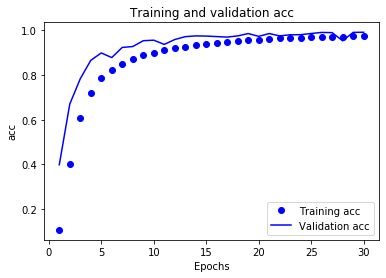

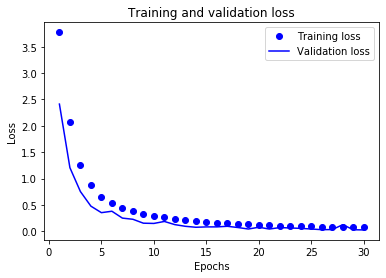

In [30]:
#####################################################################################################

# Reset Model and Data Arrays
list_channel=Best1Channel + [33]
ch_number=len(list_channel)
list_rawdataTemp=list_rawdata.copy()

    
#################################################################################################
# Construct Data Generator

GenTrainData=GenerateGeneralData( task= train_task,
                                  BatchSize=batch_size,
                                  ListRawDataMain=list_rawdataTemp.copy(),
                                  SubjectArrayShuffled=subject_number_array_shuffled,
                                  ListChannel=list_channel,
                                  RemoveBaseLineFlag=RemoveBaseLine,
                                  OrthogonalFlag=Orthogonal,
                                  WindowLen=window_len,
                                  OuterSampleShift=outer_sample_shift,
                                  InnerSampleShift=inner_sample_shift,
                                  SampelNumberPerSec=sampel_number_per_sec,
                                  ImageArrayShuffled=train_shuff)

GenValidationData =GenerateGeneralData( task= train_task,
                                        BatchSize=batch_size,
                                        ListRawDataMain=list_rawdataTemp.copy(),
                                        SubjectArrayShuffled=subject_number_array_shuffled,
                                        ListChannel=list_channel,
                                        RemoveBaseLineFlag=RemoveBaseLine,
                                        OrthogonalFlag=Orthogonal,
                                        WindowLen=window_len,
                                        OuterSampleShift=outer_sample_shift,
                                        InnerSampleShift=inner_sample_shift,
                                        SampelNumberPerSec=sampel_number_per_sec,
                                        ImageArrayShuffled=val_shuff)

GenTestData=GenerateGeneralData(task= test_task,
                                BatchSize=batch_size,
                                ListRawDataMain=list_rawdataTemp.copy(),
                                SubjectArrayShuffled=subject_number_array_shuffled,
                                ListChannel=list_channel,
                                RemoveBaseLineFlag=RemoveBaseLine,
                                OrthogonalFlag=Orthogonal,
                                WindowLen=window_len,
                                OuterSampleShift=outer_sample_shift,
                                InnerSampleShift=inner_sample_shift,
                                SampelNumberPerSec=sampel_number_per_sec,
                                ImageArrayShuffled=test_shuff)

#################################################################################################
# Create Model
model = models.Sequential()
model.add(layers.Conv2D(64, (3,3), activation = 'relu', padding='same', input_shape = (ch_number,window_len,160), data_format= "channels_first" ))
model.add(layers.MaxPooling2D((2,2)))
model.add(layers.Conv2D(128, (3,3), activation = 'relu'))
model.add(layers.MaxPooling2D((2,2)))
model.add(layers.Conv2D(256, (3,3), activation = 'relu'))
model.add(layers.MaxPooling2D((2,2)))

model.add(layers.Flatten())
model.add(layers.Dense(512, activation = 'relu'))
model.add(layers.Dropout(0.5))
model.add(layers.Dense(subject_number, activation = 'softmax'))

model.compile(loss= 'categorical_crossentropy',
              optimizer= optimizers.RMSprop(lr= 1e-4),
              metrics = ['acc'])

#################################################################################################
# Train the Model
history = model.fit_generator(epochs =30,
                              generator=GenTrainData,
                              steps_per_epoch=np.ceil(train_number*subject_number/batch_size),
                              validation_data=GenValidationData,
                              validation_steps =np.ceil(val_number*subject_number/batch_size),
                              use_multiprocessing=False,
                              workers=1)

#################################################################################################
# Evalute the Model
TrainResult      =model.evaluate_generator(GenTrainData,steps=np.ceil(train_number*subject_number/batch_size))
ValidationResult =model.evaluate_generator(GenValidationData,steps=np.ceil(val_number*subject_number/batch_size))
TestResult       =model.evaluate_generator(GenTestData,steps=np.ceil(test_number*subject_number/batch_size))
print('     TrainResult ([loss , acc])=',TrainResult)
print('ValidationResult ([loss , acc])=',ValidationResult)
print('      TestResult ([loss , acc])=',TestResult)

#################################################################################################
# plot accuracy
history_dict = history.history 
acc_values = history_dict ['acc'] 
val_acc_values = history_dict['val_acc']
epochs = range(1, len(acc_values) + 1)


#plt.clf()
plt.plot(epochs, acc_values, 'bo', label='Training acc') 
plt.plot(epochs, val_acc_values, 'b', label='Validation acc') 
plt.title('Training and validation acc') 
plt.xlabel('Epochs') 
plt.ylabel('acc') 
plt.legend()
plt.show()


history_dict = history.history 
loss_values = history_dict ['loss'] 
val_loss_values = history_dict['val_loss']
epochs = range(1, len(loss_values) + 1)

plt.plot(epochs, loss_values, 'bo', label='Training loss') 
plt.plot(epochs, val_loss_values, 'b', label='Validation loss') 
plt.title('Training and validation loss') 
plt.xlabel('Epochs') 
plt.ylabel('Loss') 
plt.legend()
plt.show()
